# Assembly Tree Generation and Evaluation

#### Formulation
 - State Space $\mathcal{S}$ = {Every Possible Subassembly}
 - Action Space $\mathcal{A}_{\hat{s}}$ = { Every Connection that can currently be removed in state $\hat{s}$ }
 - $\mathcal{T}(s'|s,a)$ = Feasability Checks
 - $R(s,a)$ = Cost of removing a certain connection in line with the dynamics 
 - Graph Assumption: Order doesn't matter

#### Remarks
 - Note that the use of "H" and "G" are switched here compared to the paper

In [2]:
import sys, random, math, time, json
import numpy as np
import pprint as pp
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from itertools import count

%matplotlib inline

## Preliminary Code (Object Classes)

# HELPER FUNCTIONS

In [3]:
# Temporary Instantiations
Rewards = {}
seqConstraint = {}


def hierarchy_pos(G, root=None, width=20., vert_gap = 0.4, vert_loc = 0, xcenter = 0.5):  
    # From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):   
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos          
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


# Generating Subassemblies in a recursive manner
def recurGen(p, H, G):
    currCon = list(H.edges())
    if(len(currCon) > 0):
        i = G.number_of_nodes() + 1
        for c in currCon:
            Hnew = H.copy()
            Hnew.remove_edges_from([c])
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                idString = str(Hnew.edges())
                nextState = next((x for x, y in nx.get_node_attributes(G,'idS').items() if y == idString), None)
                if(nextState is not None):
                    Rew, Hnew = R(p, c, H)
                    G.add_edge(p, nextState, a=c, r=Rew)
                else:
                    G.add_node(i, idS=idString)
                    Rew, Hnew = R(p,c,H)
                    G.add_edge(p, i, a=c, r=Rew)
                    G = recurGen(i, Hnew, G)
            i = G.number_of_nodes() + 1
        return G
    else:
        return G


# Getting next set of possible states and actions
def nextGen(H):
    currCon = list(H.edges())
    G = nx.DiGraph()
    G.add_node(1, value=H, idS=str(H.edges()))

    if(len(currCon) > 0):
        for c in currCon:
            i = G.number_of_nodes() + 1
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                Hnew = H.copy()
                Hnew.remove_edges_from([c])
                G.add_node(i, idS=str(Hnew.edges()))
                Rew, Hnew = R(1,c,H)
                G.add_edge(1, i, a=c, r=Rew)

                # Hnew.remove_edges_from([c])
                # G.add_node(i, idS=str(Hnew.edges()))
                # G.add_edge(1, i, a=c, r=R(1,c))
        return G
    else:
        return None
    
    
# Checking Feasability
def T(sN, s, a):
    # Sequential Constraints are already handled via the tree generation!
    pass


# Cost structure which allows for an intermediary construction zone 
# between the supply vehicle and construction area
def Rcaz(s,a,H): # Reward Function Assuming there is a CAZ
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                if(Hnew.nodes[i[0]]["loc"] == "CL"): # Going from CL to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV
                else: # Going from CAZ to SV
                    Hnew.nodes[i[0]]["loc"] = "SV"
                    Rewards[(s,a)] += -(0.0403 + 0.0420) #SV-CAZ + CAZ-SV

            elif(len(i) == 2): # Have to fix last bit problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0415) #SV-CL + CL-CAZ2

            elif(len(i) == 3): # Have to fix last problem
                for p in i:
                    if(Hnew.nodes[p]["loc"] == "CL"): # Going from CL to CAZ
                        Hnew.nodes[p]["loc"] = "CAZ"
                Rewards[(s,a)] += -(0.0307 + 0.0475) #SV-CL + CL-CAZ3
    return Rewards[(s,a)], Hnew


# Reward Function Assuming there is NO CAZ (i.e, structures are constructed at the Supply Vehicle)
def RNOcaz(s,a,H): 
    Rewards[(s,a)] = 0
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                Rewards[(s,a)] += -(0.0468 + 0.0499) #SV-CL + CL-SV

            elif(len(i) == 2):
                Rewards[(s,a)] += -(0.0749 + 0.0499) #SV-CL + CL-SV2

            elif(len(i) == 3):
                Rewards[(s,a)] += -(0.0869 + 0.0499) #SV-CL + CL-SV3
    return Rewards[(s,a)], Hnew



def Rcustom(s,a,H):
    s = str(s)
    Rewards[(s,a)] = -0.1
    
    APieces = list(nx.connected_components(H))
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    BPieces = list(nx.connected_components(Hnew))
    if(Hnew.number_of_edges() == 0): # Check if fully deconstructed
        Rewards[(s,a)] = 1
    elif(len(BPieces) - len(APieces) > 0):
        diffPieces = [list(i) for i in BPieces if i not in APieces and len(i) <= 3]
        # Check if removing last connection for a given part
        for i in diffPieces:
            # Check if creating multiple assemblies and sizes of these new assemblies
            if(len(i) == 1):
                Rewards[(s,a)] += -1 #SV-CL + CL-SV

            elif(len(i) == 2):
                Rewards[(s,a)] += -1.5 #SV-CL + CL-SV2

            elif(len(i) == 3):
                Rewards[(s,a)] += -1.75 #SV-CL + CL-SV3
    return Rewards[(s,a)], Hnew


def Rsimple(s,a,H):
    lab = str(s)
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    edges = fullE
    if(edges.index(a) <= sum(s)):
        Rewards[(lab,a)] = 1
    else:
        Rewards[(lab,a)] = 0
    return Rewards[(lab,a)], Hnew


def Rrand(s,a,H):
    lab = str(s)
    Hnew = H.copy()
    Hnew.remove_edges_from([a])
    Rewards[(lab,a)] = random.randint(0,10)
    return Rewards[(lab,a)], Hnew



# Allows you to pick which reward function to use!
def R(s, a, H):
    lab = str(s)
    if((lab,a) not in Rewards.keys()):
        Rewards[(lab,a)], Hnew = Rrand(s,a,H)
    else:
        Hnew = H.copy()
        Hnew.remove_edges_from([a])
    return Rewards[(lab,a)], Hnew

## Additional Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


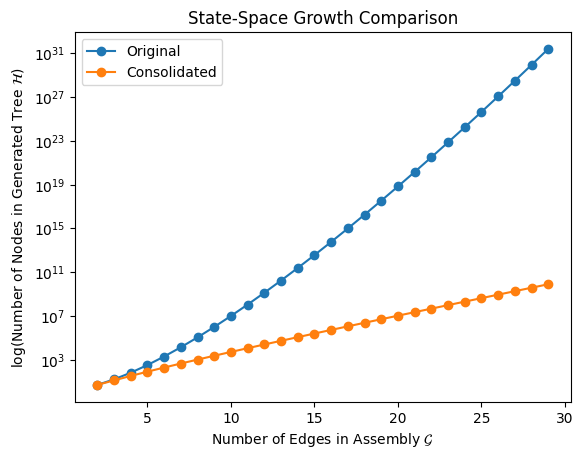

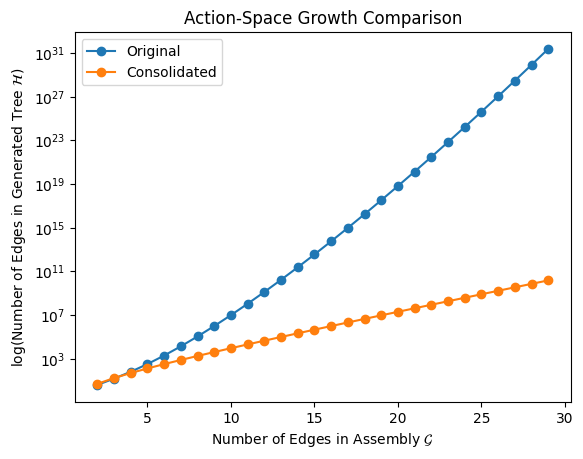

In [4]:
# State Growth Comparison
maxCon=30
con = list(range(2, maxCon))

regA = np.zeros(maxCon)
regS = np.zeros(maxCon)
conA = np.zeros(maxCon)
conS = np.zeros(maxCon)

for i in con:
    numConnections = i
    regA[i] = int(sum([float(math.factorial(numConnections))/float(math.factorial(j)) for j in range(0, numConnections)]))
    regS[i] = regA[i]+1

    conA[i] = (numConnections-1)*pow(2,numConnections) + 1
    conS[i] = numConnections*pow(2,numConnections-1) + 1

fig = plt.figure()
plt.plot(con, regS[2:], '-o')
plt.plot(con, conS[2:], '-o')
plt.yscale("log")
plt.xlabel("Number of Edges in Assembly $\mathcal{G}$")
plt.ylabel("log(Number of Nodes in Generated Tree $\mathcal{H}$)")
plt.title("State-Space Growth Comparison")
plt.legend(["Original", "Consolidated"])
plt.savefig("RESULTS/StateGrowthComparison.eps", format="eps", dpi=1200)



fig = plt.figure()
plt.plot(con, regA[2:], '-o')
plt.plot(con, conA[2:], '-o')
plt.yscale("log")
plt.yscale("log")
plt.xlabel("Number of Edges in Assembly $\mathcal{G}$")
plt.ylabel("log(Number of Edges in Generated Tree $\mathcal{H}$)")
plt.title("Action-Space Growth Comparison")
plt.legend(["Original", "Consolidated"])
plt.savefig("RESULTS/ActionGrowthComparison.eps", format="eps", dpi=1200)



## Scenario Initialization

##### "Hubble"

CONFIGURATION: 
	20 Parts,
	19 Connections in Assembly,
	4980737 Potential Subassemblies, 
	9437185 Potential Edges, 
	0 Sequential Constraints


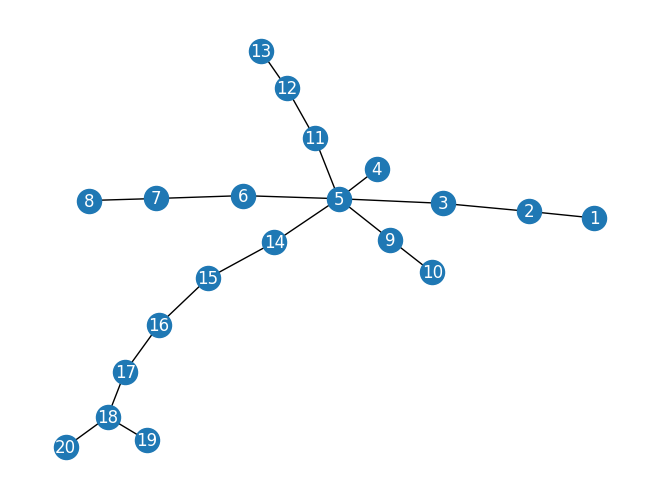

In [5]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "Hubble"

#define topology 
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,5)
H.add_edge(4,5)
H.add_edge(5,6)
H.add_edge(6,7)
H.add_edge(7,8)
H.add_edge(5,9)
H.add_edge(9,10)
H.add_edge(5,11)
H.add_edge(11,12)
H.add_edge(12,13)
H.add_edge(5,14)
H.add_edge(14,15)
H.add_edge(15,16)
H.add_edge(16,17)
H.add_edge(17,18)
H.add_edge(18,19)
H.add_edge(18,20)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Potential Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "International Space Station"

CONFIGURATION: 
	32 Parts,
	31 Connections in Assembly,
	33285996545 Subassemblies, 
	64424509441 Potential Edges, 
	0 Sequential Constraints


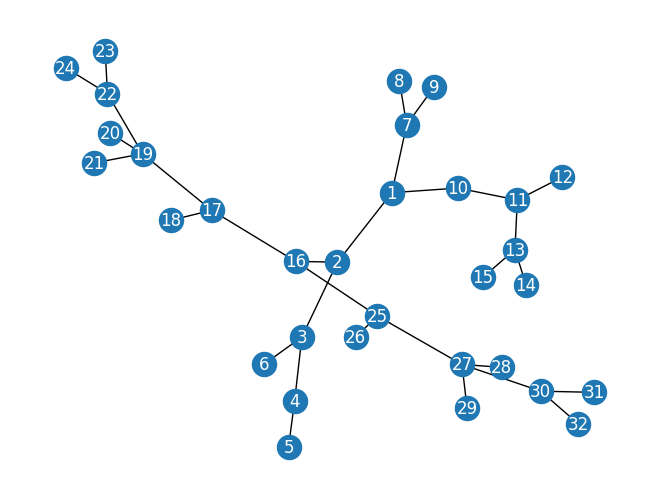

In [6]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "ISS"

#define topology
H = nx.Graph()
H.add_edges_from([(1,2), (2,3), (3,4), (4,5), (6,3), (7,1), (8,7), 
                  (9,7), (10,1), (11,10), (12,11), (13,11), (14,13), 
                  (15,13), (16,2), (17,16), (18,17), (19,17), (20,19), 
                  (21,19), (22,19), (23,22), (24,22), (25,16), (26,25), 
                  (27,25), (28,27), (29,27), (30,27), (31,30), (32,30)])
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "JWST Space Telescope"

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 20), (3, 11), (3, 14), (4, 11), (4, 14), (6, 7), (6, 8), (6, 9), (6, 10), (7, 21), (9, 11), (9, 15), (10, 11), (10, 15), (11, 12), (11, 13), (12, 14), (12, 15), (12, 20), (12, 21), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (16, 19), (16, 106), (17, 19), (18, 19), (22, 23), (22, 24), (22, 25), (22, 26), (22, 41), (24, 32), (24, 35), (25, 32), (25, 35), (27, 28), (27, 29), (27, 30), (27, 31), (28, 42), (30, 32), (30, 36), (31, 32), (31, 36), (32, 33), (32, 34), (33, 35), (33, 36), (33, 41), (33, 42), (34, 35), (34, 36), (34, 37), (34, 38), (34, 39), (37, 40), (37, 106), (38, 40), (39, 40), (43, 44), (43, 45), (43, 46), (43, 47), (43, 62), (45, 53), (45, 56), (46, 53), (46, 56), (48, 49), (48, 50), (48, 51), (48, 52), (49, 63), (51, 53), (51, 57), (52, 53), (52, 57), (53, 54), (53, 55), (54, 56), (54, 57), (54, 62), (54, 63), (55, 56), (55, 57), (55, 58), (55, 59), (55, 60), (58, 61), (58, 106), (59, 61), (60, 61), (64, 65), (64, 66), (64, 67),

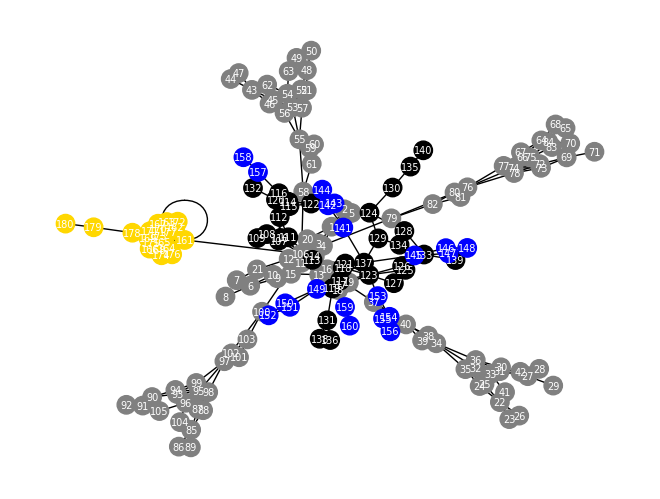

In [7]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "JWST"

#define topology
H = nx.Graph()

nodeColor = {}
N=0
# Make the 5 Gray Sleeves
for i in range(5):
      H.add_edge(N+1,N+2)
      H.add_edge(N+1,N+3)
      H.add_edge(N+1,N+4)
      H.add_edge(N+1,N+5)

      H.add_edge(N+6,N+7)
      H.add_edge(N+6,N+8)
      H.add_edge(N+6,N+9)
      H.add_edge(N+6,N+10)

      H.add_edge(N+11,N+12)
      H.add_edge(N+11,N+3)
      H.add_edge(N+11,N+4)
      H.add_edge(N+11,N+9)
      H.add_edge(N+11,N+10)

      H.add_edge(N+13,N+11)
      H.add_edge(N+13,N+14)
      H.add_edge(N+13,N+15)
      H.add_edge(N+14,N+12)
      H.add_edge(N+14,N+3)
      H.add_edge(N+14,N+4)
      H.add_edge(N+15,N+12)
      H.add_edge(N+15,N+9)
      H.add_edge(N+15,N+10)

      H.add_edge(N+16,N+13)
      H.add_edge(N+17,N+13)
      H.add_edge(N+18,N+13)
      H.add_edge(N+16,N+19)
      H.add_edge(N+17,N+19)
      H.add_edge(N+18,N+19)
      H.add_edge(N+20,N+1)
      H.add_edge(N+20,N+12)
      H.add_edge(N+21,N+7)
      H.add_edge(N+21,N+12)

      N += 21

# Connect the 5 Sleeves
H.add_edge(N+1, 16)
H.add_edge(N+1, 16+21)
H.add_edge(N+1, 16+2*21)
H.add_edge(N+1, 16+3*21)
H.add_edge(N+1, 16+4*21)

numGray = H.number_of_nodes()
nodeColor = {i:"gray" for i in range(numGray)}


# Base with solar panels
H.add_edge(N+2, N+3)
H.add_edge(N+2, N+4)
H.add_edge(N+5, N+3)
H.add_edge(N+5, N+4)
H.add_edge(N+6, N+3)
H.add_edge(N+7, N+2)
H.add_edge(N+7, N+5)
H.add_edge(N+7, N+6)
H.add_edge(N+8, N+2)
H.add_edge(N+8, N+5)
H.add_edge(N+8, N+6)

H.add_edge(N+9, N+7) # Adornments
H.add_edge(N+10, N+7)
H.add_edge(N+11, N+7)
H.add_edge(N+15, N+7)
H.add_edge(N+12, N+8)
H.add_edge(N+13, N+8)
H.add_edge(N+14, N+8)
H.add_edge(N+16, N+8)


H.add_edge(N+9, N+17) # Connection Points
H.add_edge(N+10, N+17)
H.add_edge(N+11, N+17)
H.add_edge(N+15, N+17)
H.add_edge(N+12, N+18)
H.add_edge(N+13, N+18)
H.add_edge(N+14, N+18)
H.add_edge(N+16, N+18)
H.add_edge(N+19, N+17)
H.add_edge(N+20, N+18)
H.add_edge(N+21, N+18)
H.add_edge(N+22, N+18)
H.add_edge(N+23, N+19)
H.add_edge(N+24, N+19)
H.add_edge(N+25, N+19)
H.add_edge(N+26, N+14)
H.add_edge(N+27, N+15)
H.add_edge(N+28, N+20)
H.add_edge(N+28, N+21)
H.add_edge(N+28, N+23)
H.add_edge(N+29, N+24)
H.add_edge(N+30, N+25)
H.add_edge(N+31, N+26)
H.add_edge(N+32, N+24) #INSERTS
H.add_edge(N+33, N+26)
H.add_edge(N+34, N+28)
H.add_edge(N+35, N+30)

numBlack = H.number_of_nodes()
nodeColor.update({i:"black" for i in range(numGray, numBlack)})

# 4 Solar Panels
N = H.number_of_nodes() # Reset to make numbering easier
for i in range(4):
      H.add_edge(N-4*i-3, N+1)
      H.add_edge(N+1, N+2)
      H.add_edge(N+1, N+3)
      H.add_edge(N+4, N+2)
      H.add_edge(N+4, N+3)
      N += 4
N = H.number_of_nodes()
H.add_edge(N+1, N+2)
H.add_edge(N+3, N+4)
H.add_edge(116, N+1)
H.add_edge(117, N+3)

numBlue = H.number_of_nodes()
nodeColor.update({i:"blue" for i in range(numBlack, numBlue)})

# Mirror
N = H.number_of_nodes()
H.add_edge(106,N+1)
for i in range(18):
      H.add_edge(N+1, N+i+1)
N = H.number_of_nodes()
H.add_edge(N, N+1)
H.add_edge(N+1, N+2)

numYellow = H.number_of_nodes()
nodeColor.update({i:"gold" for i in range(numBlue, numYellow)})

print(list(H.edges()))

nx.set_node_attributes(H, "CL", "loc")
numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Potential Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF", node_color=nodeColor.values(), node_size=175, font_size=7)
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "Lattice"

CONFIGURATION: 
	9 Parts,
	12 Connections in Assembly,
	24577 Subassemblies, 
	45057 Potential Edges, 
	4 Sequential Constraints


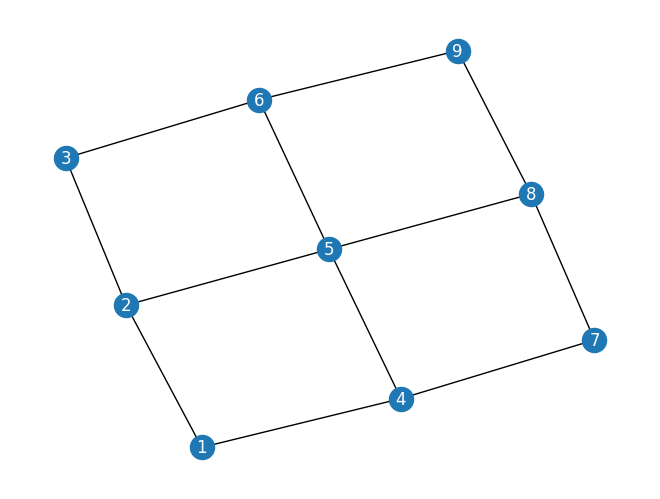

In [8]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "Lattice"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(1,4)
H.add_edge(5,4)
H.add_edge(5,2)
H.add_edge(6,5)
H.add_edge(6,3)
H.add_edge(7,4)
H.add_edge(8,7)
H.add_edge(8,5)
H.add_edge(9,8)
H.add_edge(9,6)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {(2,5): (1,4),
                 (2,5): (3,6),
                 (4,5): (1,2),
                 (4,5): (7,8),
                 (5,8): (4,7),
                 (5,8): (6,9),
                 (5,6): (2,3),
                 (5,6): (8,9)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "2 x 3"

CONFIGURATION: 
	6 Parts,
	7 Connections in Assembly,
	449 Subassemblies, 
	769 Potential Edges, 
	4 Sequential Constraints


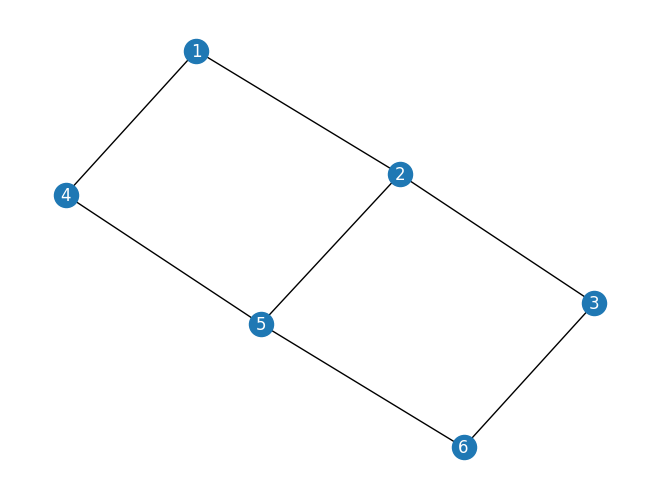

In [9]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "2x3"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(1,4)
H.add_edge(4,5)
H.add_edge(5,6)
H.add_edge(2,5)
H.add_edge(3,6)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {(2,5): (1,4),
                 (2,5): (3,6),
                 (4,5): (1,2),
                 (4,5): (7,8),
                 (5,8): (4,7),
                 (5,8): (6,9),
                 (5,6): (2,3),
                 (5,6): (8,9)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "3-Piece"

CONFIGURATION: 
	3 Parts,
	3 Connections in Assembly,
	13 Subassemblies, 
	17 Potential Edges, 
	0 Sequential Constraints


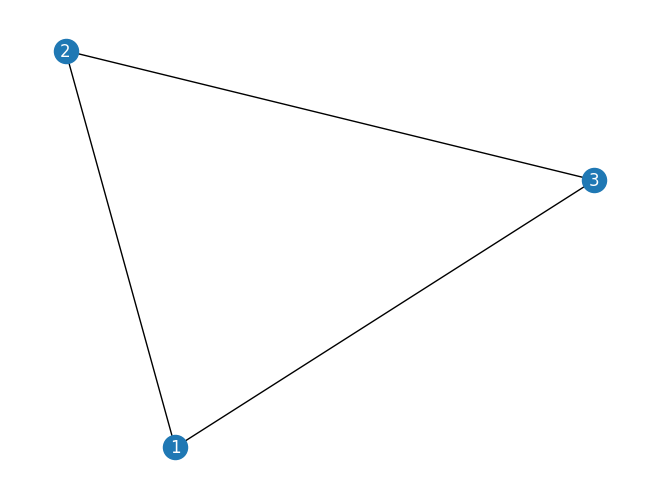

In [10]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "3Piece"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,1)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF")
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "4-Brick"

CONFIGURATION: 
	4 Parts,
	3 Connections in Assembly,
	13 Subassemblies, 
	17 Potential Edges, 
	0 Sequential Constraints


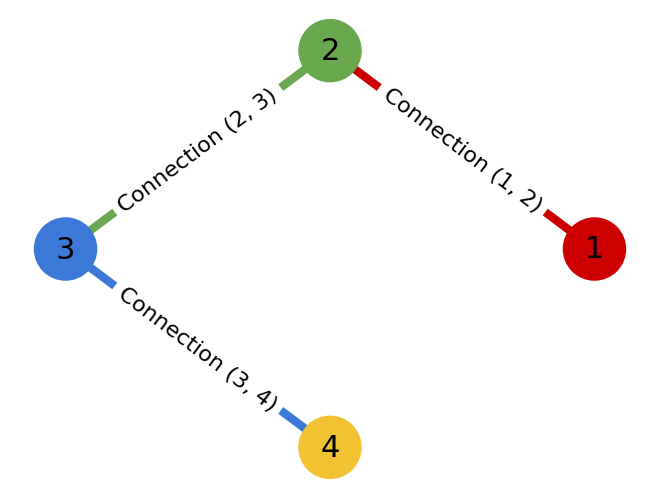

In [13]:
# Initialize the inputs (will later read in from file [JSON])

Scenario = "4Brick"

#define topology
H = nx.Graph()
H.add_edge(1,2)
H.add_edge(2,3)
H.add_edge(3,4)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

# nx.draw(H, with_labels=True, font_color="#FFFFFF")
# plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)


fig = plt.figure()
pos = nx.circular_layout(H)
nodeColor = ["#cc0000", "#6aa84f", "#3c78d8", "#f1c232"]
nx.draw(H, pos, with_labels=True, font_color="#000000", node_size=2000, font_size=22, node_color=nodeColor)
labels = {i:"Connection "+str(i) for i in H.edges()}
edgeColor = ["#cc0000", "#6aa84f", "#3c78d8"]
nx.draw_networkx_edges(H, pos, edge_color=edgeColor, width=6)
nx.draw_networkx_edge_labels(H, pos, edge_labels=labels, font_size=16)
plt.savefig("RESULTS/FullyAssembled.eps", format="eps", dpi=1200)

##### "N Long Chain"

CONFIGURATION: 
	50 Parts,
	49 Connections in Assembly,
	13792273858822145 Subassemblies, 
	27021597764222977 Potential Edges, 
	0 Sequential Constraints


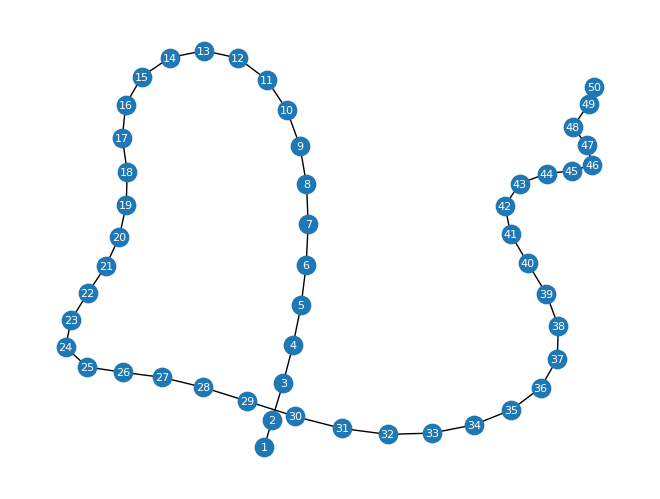

In [103]:
# Initialize the inputs (will later read in from file [JSON])
N = 50 # Number of Parts

Scenario = str(N)+"LongChain"

#define topology
H = nx.Graph()
for i in range(1,N):
    H.add_edge(i,i+1)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

nx.draw(H, with_labels=True, font_color="#FFFFFF", node_size=175, font_size=8)
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

##### "Random Tree"

CONFIGURATION: 
	100 Parts,
	99 Connections in Assembly,
	31374352355648677687043404333057 Subassemblies, 
	62114879411183240673338457063425 Potential Edges, 
	0 Sequential Constraints


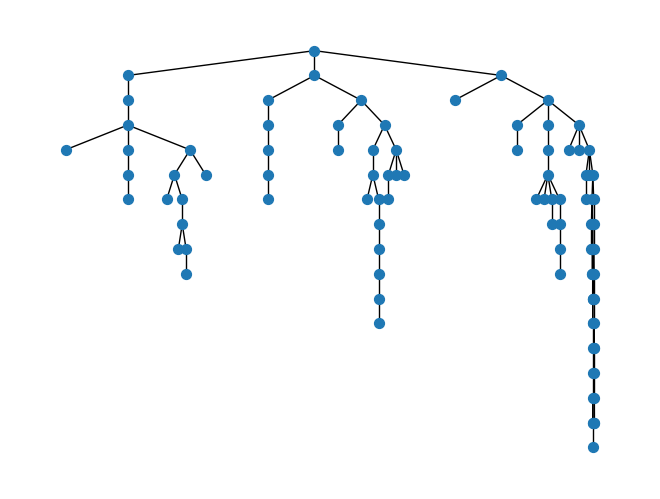

In [109]:
# Initialize the inputs (will later read in from file [JSON])
N = 100 # Number of Parts

Scenario = str(N)+"RandomTree"

#define topology
H = nx.random_tree(n=N)
nx.set_node_attributes(H, "CL", "loc")

numParts = H.number_of_nodes()
numConnections = H.number_of_edges()
numActions = (numConnections-1)*pow(2,numConnections) + 1
numStates = numConnections*pow(2,numConnections-1) + 1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}
seqConstraint = {}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

pos = hierarchy_pos(H,1)
nx.draw(H, pos, with_labels=False, node_size=50)
plt.savefig("RESULTS/"+Scenario+".eps", format="eps", dpi=1200)

## Running the Assembly Generation

In [45]:
# Simple initial initialization (will later read in from file [JSON])
Rewards = {}
fullE = list(H.edges())

# Generate the assembly tree
start = time.time()
G = nx.DiGraph()
G.add_node(1, idS=str(H.edges()))
G = recurGen(1, H, G)
end = time.time()
print("Assembly Generation Time: %f" % (end-start))

print(list(H.edges()))
print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

Assembly Generation Time: 0.000999
[(1, 2), (2, 3), (3, 4)]
DONE: 8 Nodes and 12 Edges


## Value Iteration

In [46]:
def ValueIteration(G, H, maxIter, eps):
    S = range(1, G.number_of_nodes()+1)
    A = list(H.edges())

    V = {s: 0.0 for s in S}
    Vnew = V.copy()
    π = {s: (0, (0,0)) for s in S}
    delta = max([abs(V[s] - Vnew[s]) for s in S])

    c = 0
    while(c <= maxIter):
        delta = 0
        for s in S:
            nextStates = G[s]
            for sN in nextStates.items():
                newV = sN[1]['r'] + V[sN[0]]
                if(newV > Vnew[s] or Vnew[s]==0.0):
                    Vnew[s] = newV
                    π[s] = (sN[0], sN[1]['a'])
        delta = max([abs(V[s] - Vnew[s]) for s in S])
        if(delta < eps):
            print("Converged!")
            return Vnew, π
        V = Vnew.copy()
        c += 1
    print("Done")

maxIter = 100000
eps = 1e-6
start = time.time()
V, π = ValueIteration(G, H, maxIter, eps)
end = time.time()
print("Value Iteration Time: %f" % (end-start))

Converged!
Value Iteration Time: 0.000000


# Graphing Suite

{1: (2, (1, 2)), 2: (5, (3, 4)), 3: (4, (3, 4)), 4: (0, (0, 0)), 5: (4, (2, 3)), 6: (7, (3, 4)), 7: (4, (1, 2)), 8: (7, (2, 3))}
[(1, 2), (2, 5), (5, 4)]
DONE: 8 Nodes and 12 Edges


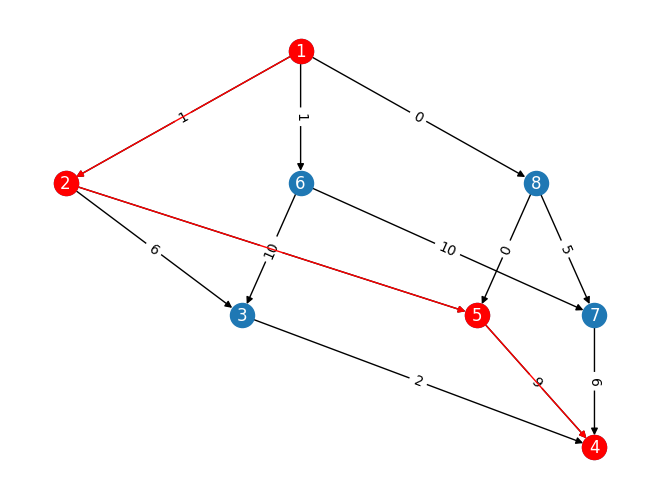

In [47]:
try:
    pos = hierarchy_pos(G,1)
except:
    pos = nx.planar_layout(G)
actions = nx.get_edge_attributes(G,'r')
#actions = {i:"Connection "+str(i) for i in G.edges()}
labels = nx.get_node_attributes(G,'r')
nx.draw(G, pos, with_labels=True, font_color="#FFFFFF")
nx.draw_networkx_edge_labels(G, pos, edge_labels = actions)
print(π)

try:
    S = range(1, G.number_of_nodes()+1)
    path = [1, π[1][0]]
    path_edges = [(1, path[-1])]
    while(True):
        currState = path[-1]
        nextState = π[currState][0]
        if(nextState in S):
            path.append(nextState)
            path_edges.append((currState, nextState))
        else:
            break
    print(path_edges)
    nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='r')
    nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='r',width=1)
except:
    print("No Policy Found")

print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))
plt.savefig("RESULTS/"+Scenario+"Result2.eps", format="eps", dpi=1200)

In [ ]:
nx.draw(H, with_labels=True, font_color="#FFFFFF")

In [ ]:
V = G.copy()
try:
    plotVis(V)
except:
    try:
        plotVis(V)
    except:
        print("Nope!")